# UMAP e t-snep, Clusters

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from sklearn import cluster, datasets

from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage, fcluster
from umap import UMAP
import umap

## Pré-tratamento dos dados: 
correlacionar os features e filtrar os valores entre ±0.1

In [35]:
# Carregar os dados
data = pd.read_excel('dh fractal.xlsx', sheet_name='meio_condi')

print(data)

        ID        grupo  MEAN FOREGROUND PIXELS  Density  Span Ratio  \
0        1      Control                     849   0.0878      2.2238   
1        2      Control                     622   0.0809      1.3106   
2        3      Control                     839   0.0825      2.6684   
3        4      Control                     708   0.0904      2.1318   
4        5      Control                     764   0.0827      1.1726   
...    ...          ...                     ...      ...         ...   
2513  2514  CM DH 2-APB                     666   0.0809      1.5134   
2514  2515  CM DH 2-APB                     951   0.0781      2.1865   
2515  2516  CM DH 2-APB                     876   0.0916      1.6099   
2516  2517  CM DH 2-APB                    1015   0.1043      1.8590   
2517  2518  CM DH 2-APB                     551   0.1141      2.9084   

     Hulls Centre of Mass  Maximum Span Across Hull   Area  Perimeter  \
0       114,8431,124,9666                  171.6858   9666   4

In [36]:
# Selecionar as características relevantes
X = data[['Slab voxels','Circularity','Area','Perimeter','Diameter of Bounding Circle','Maximum Span Across Hull', 
          'Maximum Radius from Circles Centre', 'Maximum Radius from Hulls Centre of Mass','Mean Radius from Circles Centre',
          'Mean Radius','Junction voxels','Branches','End-point voxels','Junctions','Triple points','Span Ratio',
          'Maximum BL','Avarage BL', '⋆D (D with highest r²) for Dʙ','LACUNARITY', 'Density']]

# Caracteristicas nao importantes: 'Width of Bounding Rectangle','Height of Bounding Rectangle','CV for all Radii','CV for all Radii from Circles Centre'

# Pouca variancia: Max/Min Radii from Circles Centre, Quadruple points, Max/Min Radii              

# Correlaçao positiva ± 0.8 dentre os valores com pouca variancia: Max/Min Radii

# Correlacao muito alta com outras caracteristicas: 'MEAN FOREGROUND PIXELS'

In [ ]:
# Calcular a variância das colunas
variance = X.var()

# Exibir as variâncias ordenadas
variance_sorted = variance.sort_values(ascending=False)
print(variance_sorted)

In [ ]:
# Calcular a matriz de correlação
correlation_matrix = X.corr()

# Criar uma máscara booleana para valores de correlação próximos de ± 0.8
mask = np.abs(correlation_matrix) >= 0.8

# Aplicar a máscara à matriz de correlação
filtered_correlation_matrix = correlation_matrix[mask]

# Plotar o mapa de calor da matriz de correlação filtrada
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Recursos (Features) com Valores de Correlação Próximos de Zero')
plt.show()

In [ ]:
# Obter os pares de características com correlação
pairs = filtered_correlation_matrix.stack().index.tolist()

## Imprimir os pares de características com correlação
print("Pares de características com correlação próxima do positivo:")
for pair in pairs:
    print(pair)

# UMAP
Primeiro com quase todos os valores

In [37]:
# Separar os grupos de acordo com os tratamentos
control_ = data[data['grupo'] == 'Control'].index
control_indices = data[data['grupo'] == 'CM control'].index
vehicle_indices = data[data['grupo'] == 'CM DH vehicle'].index
APB_indices = data[data['grupo'] == 'CM DH 2-APB'].index

In [ ]:
# Combine os dados de todos os grupos
all_data = pd.concat([X.loc[control_indices], X.loc[vehicle_indices], X.loc[APB_indices]])

# Criar um modelo UMAP
reducer = umap.UMAP()

# Ajustar o modelo aos dados combinados e transformá-los para o espaço reduzido
embedding_all = reducer.fit_transform(all_data)

# Separar os embeddings reduzidos para cada grupo
embedding_control = embedding_all[:len(control_indices)]
embedding_vehicle = embedding_all[len(control_indices):len(control_indices)+len(vehicle_indices)]
embedding_APB = embedding_all[len(control_indices)+len(vehicle_indices):]

# Plotar os embeddings reduzidos para cada grupo
plt.figure(figsize=(10, 8))

# Plotar grupo Control
plt.scatter(embedding_control[:, 0], embedding_control[:, 1], s=50, color='dimgray',alpha=0.6, label='Control')

# Plotar grupo CM DH vehicle
plt.scatter(embedding_vehicle[:, 0], embedding_vehicle[:, 1], s=50, color='darkorange',alpha=0.6, label='CM DH vehicle')

# Plotar grupo CM DH 2-APB
plt.scatter(embedding_APB[:, 0], embedding_APB[:, 1], s=50,color='purple',alpha=0.6, label='CM DH 2-APB')

# Calcular e plotar os centroides
centroid_control = np.mean(embedding_control, axis=0)
centroid_vehicle = np.mean(embedding_vehicle, axis=0)
centroid_APB = np.mean(embedding_APB, axis=0)

plt.scatter(centroid_control[0], centroid_control[1], marker='o', color='dimgray', s=200,edgecolor='black')
plt.scatter(centroid_vehicle[0], centroid_vehicle[1], marker='o', color='darkorange', s=200,edgecolor='black')
plt.scatter(centroid_APB[0], centroid_APB[1], marker='o', color='purple', s=200,edgecolor='black')

plt.title('UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(fontsize=15)

plt.show()

# UMAP normalizado

/Users/gabrielibovi/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


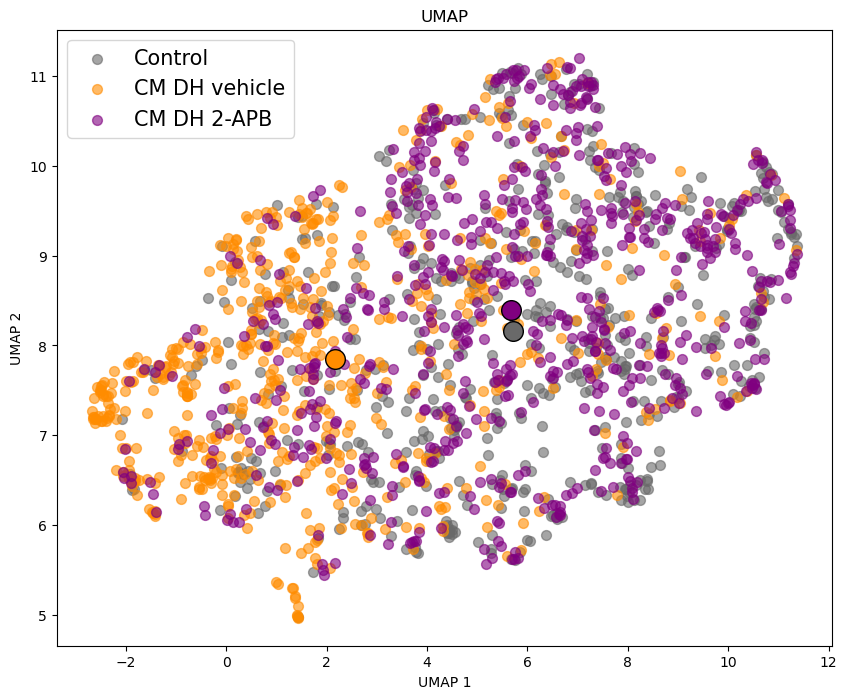

In [38]:
# Normalizar os dados de cada grupo
scaler = StandardScaler()

X_control = scaler.fit_transform(X.loc[control_indices])
X_vehicle = scaler.transform(X.loc[vehicle_indices])
X_APB = scaler.transform(X.loc[APB_indices])

# Combine os dados normalizados de todos os grupos
all_data = np.vstack((X_control, X_vehicle, X_APB))

# Criar um modelo UMAP
reducer = umap.UMAP(n_components=2, random_state=42)

# Ajustar o modelo aos dados combinados e transformá-los para o espaço reduzido
embedding_all = reducer.fit_transform(all_data)

# Separar os embeddings reduzidos para cada grupo
embedding_control = embedding_all[:len(control_indices)]
embedding_vehicle = embedding_all[len(control_indices):len(control_indices)+len(vehicle_indices)]
embedding_APB = embedding_all[len(control_indices)+len(vehicle_indices):]

# Plotar os embeddings reduzidos para cada grupo
plt.figure(figsize=(10, 8))

# Plotar grupo Control
plt.scatter(embedding_control[:, 0], embedding_control[:, 1], s=50, color='dimgray', alpha=0.6, label='Control')

# Plotar grupo CM DH vehicle
plt.scatter(embedding_vehicle[:, 0], embedding_vehicle[:, 1], s=50, color='darkorange', alpha=0.6, label='CM DH vehicle')

# Plotar grupo CM DH 2-APB
plt.scatter(embedding_APB[:, 0], embedding_APB[:, 1], s=50, color='purple', alpha=0.6, label='CM DH 2-APB')

# Calcular e plotar os centroides
centroid_control = np.mean(embedding_control, axis=0)
centroid_vehicle = np.mean(embedding_vehicle, axis=0)
centroid_APB = np.mean(embedding_APB, axis=0)

plt.scatter(centroid_control[0], centroid_control[1], marker='o', color='dimgray', s=200, edgecolor='black')
plt.scatter(centroid_vehicle[0], centroid_vehicle[1], marker='o', color='darkorange', s=200, edgecolor='black')
plt.scatter(centroid_APB[0], centroid_APB[1], marker='o', color='purple', s=200, edgecolor='black')

plt.title('UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(fontsize=15)

# Salvar a figura
#plt.savefig('UMAP_10x8_final.tiff', dpi=500) #darkblue firebrick forestgreen

plt.show()

## UMAP 3D

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Normalizar os dados de cada grupo
scaler = StandardScaler()

X_control = scaler.fit_transform(X.loc[control_indices])
X_vehicle = scaler.transform(X.loc[vehicle_indices])
X_APB = scaler.transform(X.loc[APB_indices])

# Combine os dados normalizados de todos os grupos
all_data = np.vstack((X_control, X_vehicle, X_APB))

# Criar um modelo UMAP com 3 componentes
reducer = umap.UMAP(n_components=3, random_state=42)

# Ajustar o modelo aos dados combinados e transformá-los para o espaço reduzido
embedding_all = reducer.fit_transform(all_data)

# Separar os embeddings reduzidos para cada grupo
embedding_control = embedding_all[:len(control_indices)]
embedding_vehicle = embedding_all[len(control_indices):len(control_indices)+len(vehicle_indices)]
embedding_APB = embedding_all[len(control_indices)+len(vehicle_indices):]

# Plotar os embeddings reduzidos para cada grupo em 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotar grupo Control
ax.scatter(embedding_control[:, 0], embedding_control[:, 1], embedding_control[:, 2], s=50, color='dimgray', alpha=0.6, label='Control')

# Plotar grupo CM DH vehicle
ax.scatter(embedding_vehicle[:, 0], embedding_vehicle[:, 1], embedding_vehicle[:, 2], s=50, color='darkorange', alpha=0.6, label='CM DH vehicle')

# Plotar grupo CM DH 2-APB
ax.scatter(embedding_APB[:, 0], embedding_APB[:, 1], embedding_APB[:, 2], s=50, color='purple', alpha=0.6, label='CM DH 2-APB')

# Calcular e plotar os centroides
centroid_control = np.mean(embedding_control, axis=0)
centroid_vehicle = np.mean(embedding_vehicle, axis=0)
centroid_APB = np.mean(embedding_APB, axis=0)

ax.scatter(centroid_control[0], centroid_control[1], centroid_control[2], marker='o', color='dimgray', s=200, edgecolor='black')
ax.scatter(centroid_vehicle[0], centroid_vehicle[1], centroid_vehicle[2], marker='o', color='darkorange', s=200, edgecolor='black')
ax.scatter(centroid_APB[0], centroid_APB[1], centroid_APB[2], marker='o', color='purple', s=200, edgecolor='black')

# Configurar rótulos e título
ax.set_title('UMAP 3D')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.legend(fontsize=14)
ax.view_init(20,50)
plt.show()

# HCA

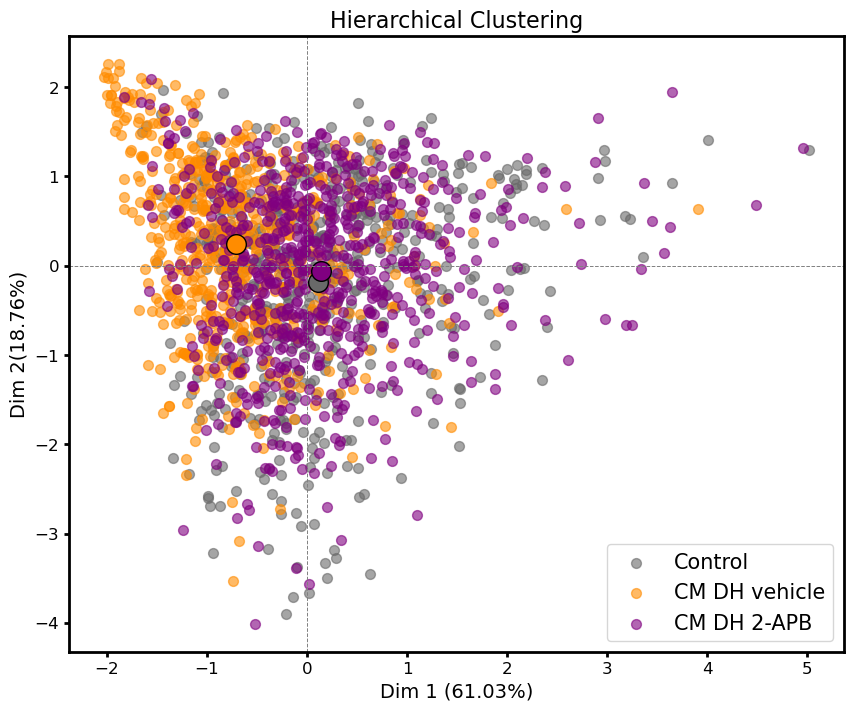

In [39]:
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Aplicar o PCA
pca = PCA(0.95)
X_pca = pca.fit_transform(X_normalized)

# Aplicar o agrupamento hierárquico
B = linkage(X_pca, method='ward')

# Definir o número de clusters desejados
num_clusters = 3

# Realizar o clustering hierárquico e obter os rótulos dos clusters
labels = fcluster(B, num_clusters, criterion='maxclust')

# Plotar
plt.figure(figsize=(10, 8))

plt.scatter(X_normalized[control_indices, 0], X_normalized[control_indices, 1], label='Control', color='dimgray', alpha=0.6, s=50)
plt.scatter(X_normalized[vehicle_indices, 0], X_normalized[vehicle_indices, 1], label='CM DH vehicle', color='darkorange', alpha=0.6, s=50)
plt.scatter(X_normalized[APB_indices, 0], X_normalized[APB_indices, 1], label='CM DH 2-APB', color='purple', alpha=0.6, s=50)

# Calcular os centroides de cada grupo
centroid_control = np.mean(X_normalized[control_indices], axis=0)
centroid_vehicle = np.mean(X_normalized[vehicle_indices], axis=0)
centroid_APB = np.mean(X_normalized[APB_indices], axis=0)

# Plotar os centroides
plt.scatter(centroid_control[0], centroid_control[1], marker='o', color='dimgray',s=200, edgecolor='black')
plt.scatter(centroid_vehicle[0], centroid_vehicle[1], marker='o', color='darkorange', s=200, edgecolor='black')
plt.scatter(centroid_APB[0], centroid_APB[1], marker='o', color='purple', s=200, edgecolor='black')

# Adicionar linhas de referência para os eixos
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)

# Adicionar nomes das características e variáveis nos eixos
plt.gca().tick_params(axis='x', labelsize=12, width=2, grid_color= 'black')  
plt.gca().tick_params(axis='y', labelsize=12, width=2)
plt.xlabel(f"Dim 1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)", fontsize=14)
plt.ylabel(f"Dim 2({pca.explained_variance_ratio_[1] * 100:.2f}%)", fontsize=14)

# Ajustar a espessura das linhas dos eixos x e y
plt.gca().spines[['bottom','left','top', 'right']].set_linewidth(2)

plt.title('Hierarchical Clustering',fontsize=16)
plt.legend(fontsize=15)

# Salvar a figura
#plt.savefig('HCA_10x8_final.tiff.tiff')

plt.show()

In [ ]:
# Plotar os clusters em um gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot para cada grupo
ax.scatter(X_normalized[control_indices, 0], X_normalized[control_indices, 1], X_normalized[control_indices, 2], label='Control', color='dimgray', alpha=0.6, s=50)
ax.scatter(X_normalized[vehicle_indices, 0], X_normalized[vehicle_indices, 1], X_normalized[vehicle_indices, 2], label='CM DH vehicle', color='darkorange', alpha=0.6, s=50)
ax.scatter(X_normalized[APB_indices, 0], X_normalized[APB_indices, 1], X_normalized[APB_indices, 2], label='CM DH 2-APB', color='purple', alpha=0.6, s=50)

# Adicionar nomes das características e variáveis nos eixos
plt.gca().tick_params(axis='x', labelsize=12, width=2, grid_color= 'black')  
plt.gca().tick_params(axis='y', labelsize=12, width=2)
plt.gca().tick_params(axis='z', labelsize=12, width=2)
ax.set_xlabel(f"{X.columns[0]} ({pca.explained_variance_ratio_[0] * 100:.2f}%)", fontsize=14)
ax.set_ylabel(f"{X.columns[1]} ({pca.explained_variance_ratio_[1] * 100:.2f}%)", fontsize=14)
ax.set_zlabel(f"{X.columns[2]} ({pca.explained_variance_ratio_[2] * 100:.2f}%)", fontsize=14)

# Ajustar a espessura das linhas dos eixos x e y
plt.gca().spines[['bottom','left','top', 'right']].set_linewidth(2)

plt.title('Hierarchical Clustering 3D',fontsize=15)
plt.legend(fontsize=15)

ax.view_init(20,50)

# Salvar a figura
#plt.savefig('HC_cmcontrol_2apb_3d.tiff')

plt.show()

## t-SNE

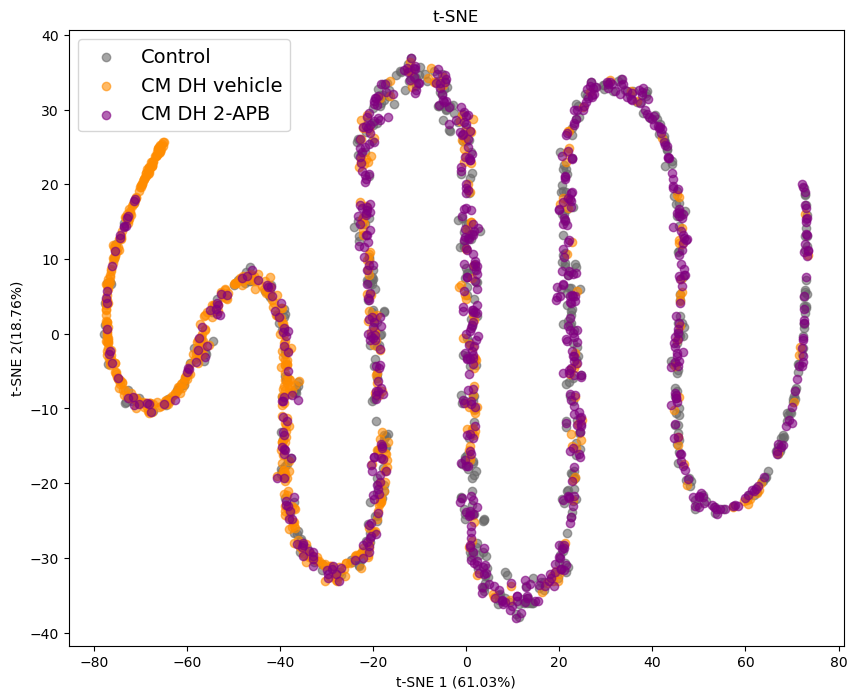

In [40]:
from sklearn.manifold import TSNE

# Aplicar t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Aplicar o agrupamento hierárquico
Z = linkage(X_tsne, method='ward')

# Definir o número de clusters desejados
num_clusters = 3

# Realizar o clustering hierárquico e obter os rótulos dos clusters
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Plotar
plt.figure(figsize=(10, 8))

plt.scatter(X_tsne[control_indices, 0], X_tsne[control_indices, 1], label='Control', color='dimgray', alpha=0.6)
plt.scatter(X_tsne[vehicle_indices, 0], X_tsne[vehicle_indices, 1], label='CM DH vehicle', color='darkorange', alpha=0.6)
plt.scatter(X_tsne[APB_indices, 0], X_tsne[APB_indices, 1], label='CM DH 2-APB', color='purple', alpha=0.6)

# Adicionar nomes das características e variáveis nos eixos
plt.xlabel(f"t-SNE 1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
plt.ylabel(f"t-SNE 2({pca.explained_variance_ratio_[1] * 100:.2f}%)")

plt.title('t-SNE')
plt.legend(fontsize=14)

# Salvar a figura
#plt.savefig('tsne_10x8_final.tiff.tiff')

plt.show()

# Agora realizar o dendrograma, Elbow, HCA para cada grupo

### Controle

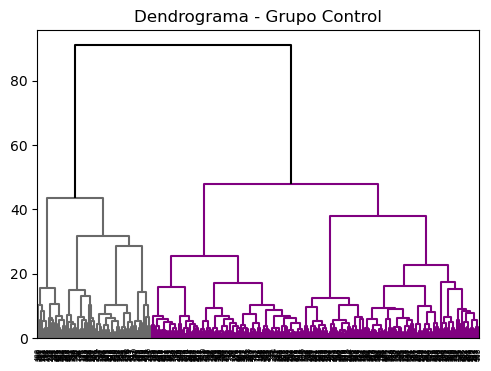

In [26]:
from scipy.cluster import hierarchy

# Selecionar as características relevantes para o grupo 'control_indices'
X_control = X.loc[control_indices]

# Normalizar os dados usando StandardScaler, se necessário
scaler = StandardScaler()
control_norma = scaler.fit_transform(X_control)

# Definir o tamanho da figura
plt.figure(figsize=(5.7, 4))

# Definir o limite de cor para os clusters
color_threshold = 50
distance_threshold = 50

# Calcular a matriz de ligação para o dendrograma
linkage_matrix = hierarchy.linkage(control_norma, method='ward')

# Definir a paleta de cores personalizada
colors = ['dimgray', 'purple', 'darkorange']
hierarchy.set_link_color_palette(colors)

# Plotar o dendrograma com cores para os clusters
dendrogram = hierarchy.dendrogram(linkage_matrix, color_threshold=color_threshold, distance_threshold)

# Resetar a paleta de cores para o padrão
hierarchy.set_link_color_palette(None)

# Alterar a cor da primeira linha que liga os clusters principais, se necessário
plt.gca().get_children()[2].set_color('black')

plt.title('Dendrograma - Grupo Control')

# Salvar a figura
#plt.savefig('dendro_CM_control.tiff', dpi=500)

plt.show()

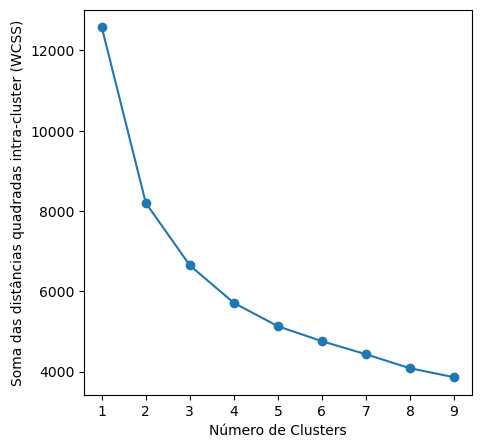

In [7]:
# Função para calcular a soma dos quadrados dentro dos clusters
def calculate_wcss(data):
    wcss = []
    for n in range(1, 10):
        kmeans = KMeans(n_clusters=n, init='k-means++')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Função para determinar o número ideal de clusters
def optimal_number_of_clusters(wcss):
    differences = []
    for i in range(len(wcss)-1):
        differences.append(wcss[i] - wcss[i+1])
    return differences.index(max(differences)) + 1

# Calcular a WCSS para diferentes números de clusters
wcss = calculate_wcss(control_norma)

# Determinar o número ideal de clusters
n = optimal_number_of_clusters(wcss)

# Executar o K-Means com o número ideal de clusters
kmeans = KMeans(n_clusters=n, init='k-means++')
clusters = kmeans.fit_predict(control_norma)

# Plotar a soma das distâncias quadradas intra-cluster (WCSS)
plt.figure(figsize=(5, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma das distâncias quadradas intra-cluster (WCSS)')

# Salvar a figura
#plt.savefig('Número de Clusters.png') 

plt.show()

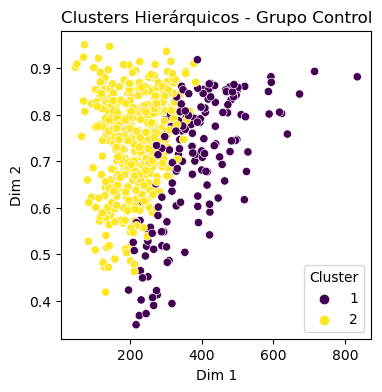

In [10]:
# Calcular a matriz de ligação (linkage matrix) usando o método de Ward
Z = linkage(control_norma, method='ward')

# Definir o número de clusters desejados
num_clusters = 2

# Realizar o clustering hierárquico e obter os rótulos dos clusters
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Adicionar os rótulos dos clusters aos dados originais
X_control_clustered = X_control.copy()
X_control_clustered['Cluster'] = labels

# Visualizar os clusters usando um par de características
plt.figure(figsize=(4, 4))
sns.scatterplot(x=X_control_clustered.iloc[:, 0], y=X_control_clustered.iloc[:, 1], hue='Cluster', palette='viridis', data=X_control_clustered)
plt.title('Clusters Hierárquicos - Grupo Control')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend(title='Cluster')

# Salvar a figura
#plt.savefig('HCA_CM_control.tiff', dpi=500)

plt.show()

### Vehicle

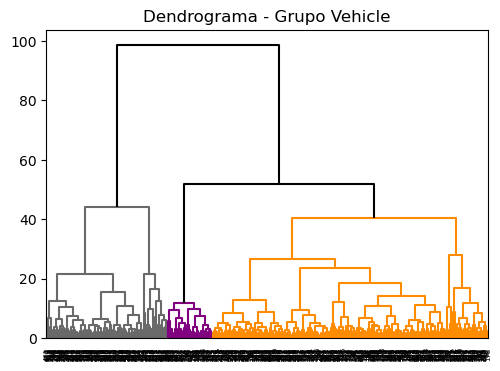

In [30]:
# Selecionar as características relevantes para o grupo 'control_indices'
X_vehicle = X.loc[vehicle_indices]

# Normalizar os dados usando StandardScaler, se necessário
scaler = StandardScaler()
vehicle_norma = scaler.fit_transform(X_vehicle)

# Definir o tamanho da figura
plt.figure(figsize=(5.7, 4))

# Definir o limite de cor para os clusters
color_threshold = 50
distance_threshold = 50

# Calcular a matriz de ligação para o dendrograma
linkage_matrix = hierarchy.linkage(vehicle_norma, method='ward')

# Definir a paleta de cores personalizada
colors = ['dimgray', 'purple', 'darkorange']
hierarchy.set_link_color_palette(colors)

# Plotar o dendrograma com cores para os clusters
dendrogram = hierarchy.dendrogram(linkage_matrix, color_threshold=color_threshold)

# Resetar a paleta de cores para o padrão
hierarchy.set_link_color_palette(None)

# Alterar a cor da primeira linha que liga os clusters principais, se necessário
plt.gca().get_children()[3].set_color('black')

plt.title('Dendrograma - Grupo Vehicle')

# Salvar a figura
#plt.savefig('dendro_CM_vehicle.tiff', dpi=500)

plt.show()

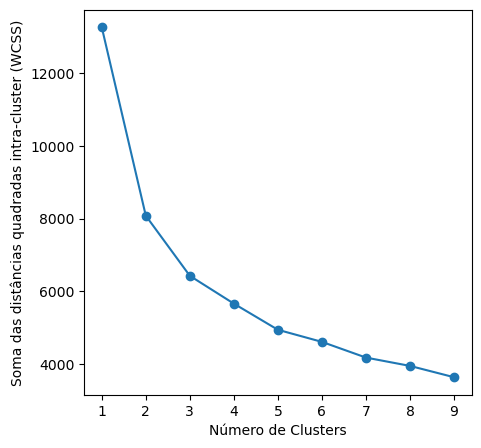

In [12]:
# Função para calcular a soma dos quadrados dentro dos clusters
def calculate_wcss(data):
    wcss = []
    for n in range(1, 10):
        kmeans = KMeans(n_clusters=n, init='k-means++')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Função para determinar o número ideal de clusters
def optimal_number_of_clusters(wcss):
    differences = []
    for i in range(len(wcss)-1):
        differences.append(wcss[i] - wcss[i+1])
    return differences.index(max(differences)) + 1

# Calcular a WCSS para diferentes números de clusters
wcss = calculate_wcss(vehicle_norma)

# Determinar o número ideal de clusters
n = optimal_number_of_clusters(wcss)

# Executar o K-Means com o número ideal de clusters
kmeans = KMeans(n_clusters=n, init='k-means++')
clusters = kmeans.fit_predict(vehicle_norma)

# Plotar a soma das distâncias quadradas intra-cluster (WCSS)
plt.figure(figsize=(5, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma das distâncias quadradas intra-cluster (WCSS)')

# Salvar a figura
#plt.savefig('Número de Clusters.png') 

plt.show()

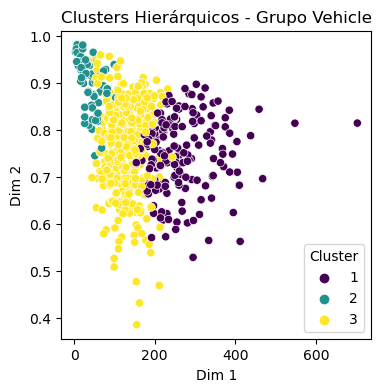

In [31]:
# Calcular a matriz de ligação (linkage matrix) usando o método de Ward
Z = linkage(vehicle_norma, method='ward')

# Definir o número de clusters desejados
num_clusters = 3

# Realizar o clustering hierárquico e obter os rótulos dos clusters
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Adicionar os rótulos dos clusters aos dados originais
X_vehicle_clustered = X_vehicle.copy()
X_vehicle_clustered['Cluster'] = labels

# Visualizar os clusters usando um par de características
plt.figure(figsize=(4, 4))
sns.scatterplot(x=X_vehicle_clustered.iloc[:, 0], y=X_vehicle_clustered.iloc[:, 1], hue='Cluster', palette='viridis', data=X_vehicle_clustered)
plt.title('Clusters Hierárquicos - Grupo Vehicle')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend(title='Cluster')

# Salvar a figura
#plt.savefig('HCA_CM_vehicle.tiff', dpi=500)

plt.show()

### 2APB

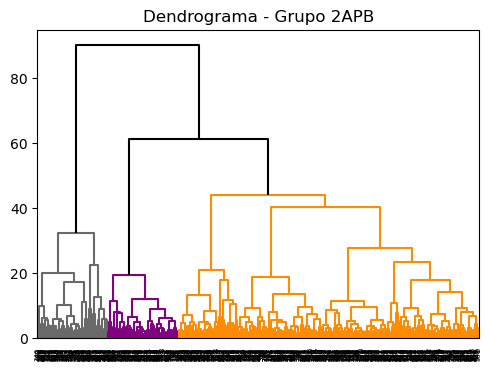

In [32]:
# Selecionar as características relevantes para o grupo 'APB_indices'
X_apb = X.loc[APB_indices]

# Normalizar os dados usando StandardScaler
scaler = StandardScaler()
apb_norma = scaler.fit_transform(X_apb)

# Definir o tamanho da figura
plt.figure(figsize=(5.7, 4))

# Definir o limite de cor para os clusters
color_threshold = 50
distance_threshold = 50

# Calcular a matriz de ligação para o dendrograma
linkage_matrix = hierarchy.linkage(apb_norma, method='ward')

# Definir a paleta de cores personalizada
colors = ['dimgray', 'purple', 'darkorange']
hierarchy.set_link_color_palette(colors)

# Plotar o dendrograma com cores para os clusters
dendrogram = hierarchy.dendrogram(linkage_matrix, color_threshold=color_threshold)

# Resetar a paleta de cores para o padrão
hierarchy.set_link_color_palette(None)

# Alterar a cor da primeira linha que liga os clusters principais, se necessário
plt.gca().get_children()[3].set_color('black')

plt.title('Dendrograma - Grupo 2APB')

# Salvar a figura
#plt.savefig('dendro_CM_2apb.tiff', dpi=500)

plt.show()

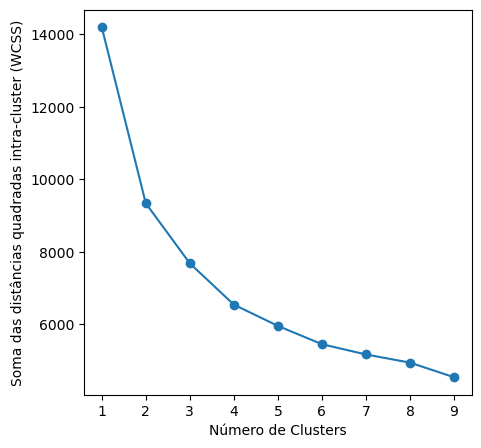

In [17]:
# Função para calcular a soma dos quadrados dentro dos clusters
def calculate_wcss(data):
    wcss = []
    for n in range(1, 10):
        kmeans = KMeans(n_clusters=n, init='k-means++')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Função para determinar o número ideal de clusters
def optimal_number_of_clusters(wcss):
    differences = []
    for i in range(len(wcss)-1):
        differences.append(wcss[i] - wcss[i+1])
    return differences.index(max(differences)) + 1

# Calcular a WCSS para diferentes números de clusters
wcss = calculate_wcss(apb_norma)

# Determinar o número ideal de clusters
n = optimal_number_of_clusters(wcss)

# Executar o K-Means com o número ideal de clusters
kmeans = KMeans(n_clusters=n, init='k-means++')
clusters = kmeans.fit_predict(apb_norma)

# Plotar a soma das distâncias quadradas intra-cluster (WCSS)
plt.figure(figsize=(5, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma das distâncias quadradas intra-cluster (WCSS)')

# Salvar a figura
#plt.savefig('Número de Clusters.png') 

plt.show()

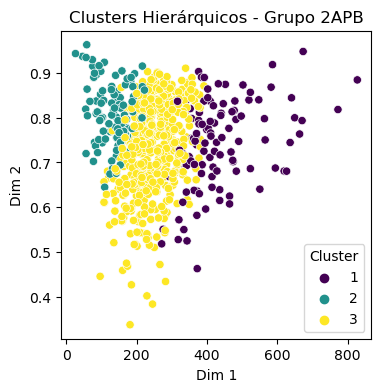

In [33]:
# Calcular a matriz de ligação (linkage matrix) usando o método de Ward
Z = linkage(apb_norma, method='ward')

# Definir o número de clusters desejados
num_clusters = 3

# Realizar o clustering hierárquico e obter os rótulos dos clusters
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Adicionar os rótulos dos clusters aos dados originais
X_apb_clustered = X_apb.copy()
X_apb_clustered['Cluster'] = labels

# Visualizar os clusters usando um par de características
plt.figure(figsize=(4, 4))
sns.scatterplot(x=X_apb_clustered.iloc[:, 0], y=X_apb_clustered.iloc[:, 1], hue='Cluster', palette='viridis', data=X_apb_clustered)
plt.title('Clusters Hierárquicos - Grupo 2APB')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend(title='Cluster')

# Salvar a figura
#plt.savefig('HCA_CM_2apb.tiff', dpi=500)

plt.show()

# Salvar em excel

/var/folders/zc/k5kwl88941l5s3w2wfb0t2c80000gn/T/ipykernel_17322/3756388943.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Cluster'] = cluster_labels
/var/folders/zc/k5kwl88941l5s3w2wfb0t2c80000gn/T/ipykernel_17322/3756388943.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Cluster'] = cluster_labels
/var/folders/zc/k5kwl88941l5s3w2wfb0t2c80000gn/T/ipykernel_17322/3756388943.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

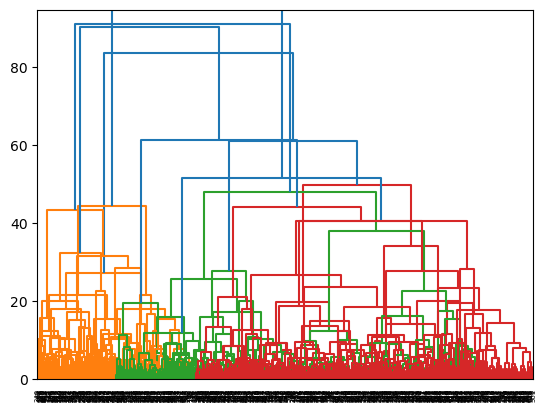

In [34]:
# Carregar os dados
data = pd.read_excel('dh fractal.xlsx', sheet_name='meio_condi')

# Separar os dados por grupo
groups = data['grupo'].unique()

for group in groups:
    # Selecionar os dados do grupo atual
    group_data = data[data['grupo'] == group]
    
    # Selecionar as colunas relevantes
    X = group_data[['Slab voxels','Circularity','Area','Perimeter','Diameter of Bounding Circle','Maximum Span Across Hull', 
          'Maximum Radius from Circles Centre', 'Maximum Radius from Hulls Centre of Mass','Mean Radius from Circles Centre',
          'Mean Radius','Junction voxels','Branches','End-point voxels','Junctions','Triple points','Span Ratio',
          'Maximum BL','Avarage BL', '⋆D (D with highest r²) for Dʙ','LACUNARITY', 'Density']]
    
    # Normalizar os dados
    X_normalized = StandardScaler().fit_transform(X)
    
    # Calcular a matriz de ligação para o dendrograma
    linkage_matrix = hierarchy.linkage(X_normalized, method='ward')
    
    # Definir o limite de cor para os clusters
    color_threshold = 50
    
    # Plotar o dendrograma com cores para os clusters
    dendrogram = hierarchy.dendrogram(linkage_matrix, color_threshold=color_threshold)
    
    # Obter os rótulos dos clusters com base no limite de distância
    distance_threshold = 50 
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    # Adicionar os rótulos dos clusters ao DataFrame original
    group_data['Cluster'] = cluster_labels
    
    # Salvar o DataFrame em um arquivo Excel
    #group_data.to_excel(f'clusters_{group}.xlsx', index=False)